<a href="https://colab.research.google.com/github/jowinjestine/Automated_Data_Cleaning/blob/main/Audio_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
colab_requirements = [
    "pip install tensorflow-gpu==2.0.0-beta0",
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",
]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Created wheel for noisereduce: filename=noisereduce-1.1.0-cp36-none-any.whl size=7610 sha256=e1ef3468496b4d72405cfd0e0daee03e48530fa0b60cd1d1cab27da8629b03e6
Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce


In [ ]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
import librosa.util as lr
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
!pip install SpeechRecognition
!apt-get install -y swig libpulse-dev
!pip install pocketsphinx

     |████████████████████████████████| 32.8MB 126kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpulse-mainloop-glib0 swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  libpulse-dev libpulse-mainloop-glib0 swig swig3.0
0 upgraded, 4 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,204 kB of archives.
After this operation, 6,538 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpulse-mainloop-glib0 amd64 1:11.1-1ubuntu7.10 [22.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpulse-dev amd64 1:11.1-1ubuntu7.10 [81.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B

In [ ]:
import speech_recognition as sr

In [ ]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))

In [ ]:
noise_len = 4 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

In [ ]:
a=lr.normalize(audio_clip_band_limited,norm=1)

In [ ]:
#sf.write('stereo.wav', a, rate, subtype='PCM_24')

In [ ]:
def spe(y: np.ndarray, fs: int) -> dict:
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1 / fs)
    spec = np.abs(spec)
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    sd = np.sqrt(np.sum(amp * ((freq - mean) ** 2)))
    amp_cumsum = np.cumsum(amp)
    median = freq[len(amp_cumsum[amp_cumsum <= 0.5]) + 1]
    mode = freq[amp.argmax()]
    Q10 = freq[len(amp_cumsum[amp_cumsum <= 0.10]) + 1]
    Q90 = freq[len(amp_cumsum[amp_cumsum <= 0.90]) + 1]
    Q100 = freq[len(amp_cumsum[amp_cumsum <= 0.99]) + 1]
    Q1 = freq[len(amp_cumsum[amp_cumsum <= 0.01]) + 1]
    #IQR = Q90 - Q10
    z = amp - amp.mean()
    w = amp.std()
    skew = ((z ** 3).sum() / (len(spec) - 1)) / w ** 3
    kurt = ((z ** 4).sum() / (len(spec) - 1)) / w ** 4

    result_d = {
        'mean': mean,
        'sd': sd,
        'median': median,
        'mode': mode,
        'Q10': Q10,
        'Q90': Q90,
        'Q1': Q1,
        'Q100': Q100,
        'skew': skew,
        'kurt': kurt
    }
    print(result_d)
    return mean

In [ ]:
mean=spe(a,rate)

{'mean': 3017.640723724819, 'sd': 2806.0737455999924, 'median': 2084.4705847154214, 'mode': 578.1277737331831, 'Q10': 478.9510426743525, 'Q90': 7513.462017931406, 'Q1': 188.45777941777783, 'Q100': 11557.277777223724, 'skew': 4.4991145524106635, 'kurt': 34.64410874182298}


In [ ]:
fft_a=np.fft.fft(a)

In [ ]:
print(fft_a)

[ 9.37148895e-08+1.51788304e-18j  7.42969623e-07+2.18402950e-06j
  2.48889576e-07+1.72815984e-07j ... -4.64622035e-07+2.16979517e-07j
  2.48889576e-07-1.72815984e-07j  7.42969623e-07-2.18402950e-06j]


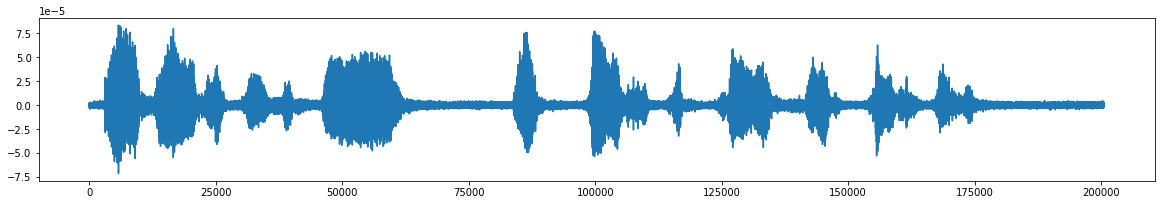

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(a)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


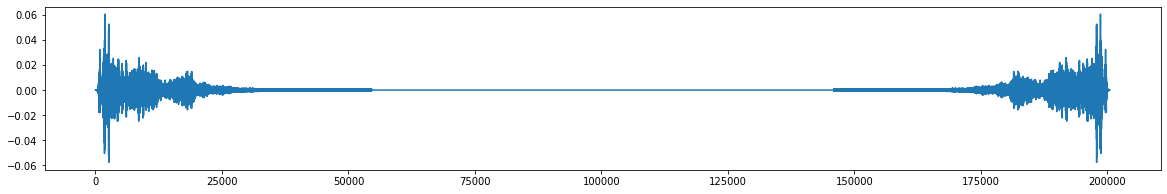

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(fft_a)

In [ ]:
import numpy as np
from scipy.signal import butter,filtfilt
# Filter requirements.
T = len(data)/rate         # Sample Period
fs = rate       # sample rate, Hz
cutoff = mean+500      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 4       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [ ]:
nyq = 0.5 * rate
print(nyq)

22050.0


In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b1, b2 = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b1, b2, data)
    return y
    

In [ ]:
y = butter_lowpass_filter(data, cutoff, fs, order)

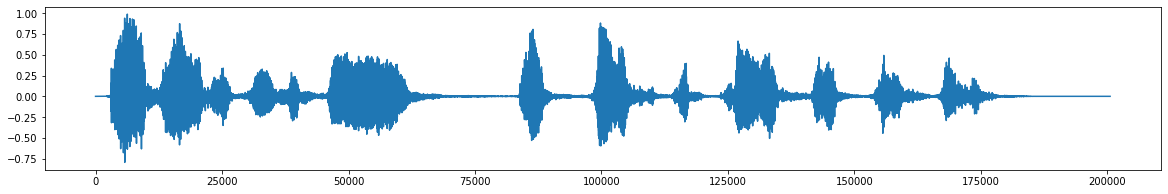

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(y)

In [ ]:
spe(a,rate)
spe(y,rate)

{'mean': 3017.640723724819, 'sd': 2806.0737455999924, 'median': 2084.4705847154214, 'mode': 578.1277737331831, 'Q10': 478.9510426743525, 'Q90': 7513.462017931406, 'Q1': 188.45777941777783, 'Q100': 11557.277777223724, 'skew': 4.4991145524106635, 'kurt': 34.64410874182298}
{'mean': 1519.2149250819393, 'sd': 1010.4244409003601, 'median': 1339.875437564201, 'mode': 578.1277737331831, 'Q10': 413.4196327951252, 'Q90': 2904.053016325757, 'Q1': 175.70334393792822, 'Q100': 4184.334453630661, 'skew': 5.0246911376504855, 'kurt': 39.86389397425493}


1519.2149250819393

In [ ]:
IPython.display.Audio(data=a, rate=rate)

In [ ]:
IPython.display.Audio(data=y, rate=rate)

In [ ]:
IPython.display.Audio(data=jowin, rate=rate)

In [ ]:
import scipy
from scipy.io.wavfile import read
from scipy.signal import hann
from scipy.fftpack import rfft
import matplotlib.pyplot as plt

# read audio samples
#input_data = read("stereo")
audio = data
# apply a Hanning window
window = hann(len(data))
audio = audio * window
# fft
mags = abs(rfft(audio))
"""
# convert to dB
mags = 20 * np.log10(mags)
# normalise to 0 dB max
mags -= max(mags)
# plot
plt.plot(mags)
# label the axes
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequency Bin")
# set the title
plt.title("Flute Spectrum")
plt.show()
"""

'\n# convert to dB\nmags = 20 * np.log10(mags)\n# normalise to 0 dB max\nmags -= max(mags)\n# plot\nplt.plot(mags)\n# label the axes\nplt.ylabel("Magnitude (dB)")\nplt.xlabel("Frequency Bin")\n# set the title\nplt.title("Flute Spectrum")\nplt.show()\n'

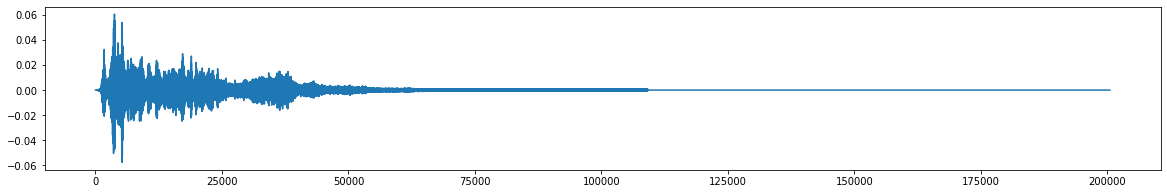

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(jowin)

In [ ]:
jowin=scipy.fftpack.rfft(a)
print(jowin)

[ 9.37148895e-08  7.42969623e-07  2.18402950e-06 ... -1.76647456e-07
  2.88439007e-07 -2.50750650e-07]


In [ ]:
a

array([ 2.05012236e-07,  1.55170671e-07, -2.48289962e-07, ...,
        1.14311013e-06, -6.81016351e-07, -7.70046591e-07])

In [ ]:
# harvard = sr.AudioFile(url)
# r = sr.Recognizer()
# with harvard as source:
#   audio = r.record(source)